Classification Problem

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, classification_report


In [8]:
cancer = datasets.load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target, name= 'target')

data = pd.concat([X, y], axis = 1)

print(f'Independent variables shape: {X.shape}')
print(f'Null Values: {data.isnull().sum()}')

Independent variables shape: (569, 30)
Null Values: mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64


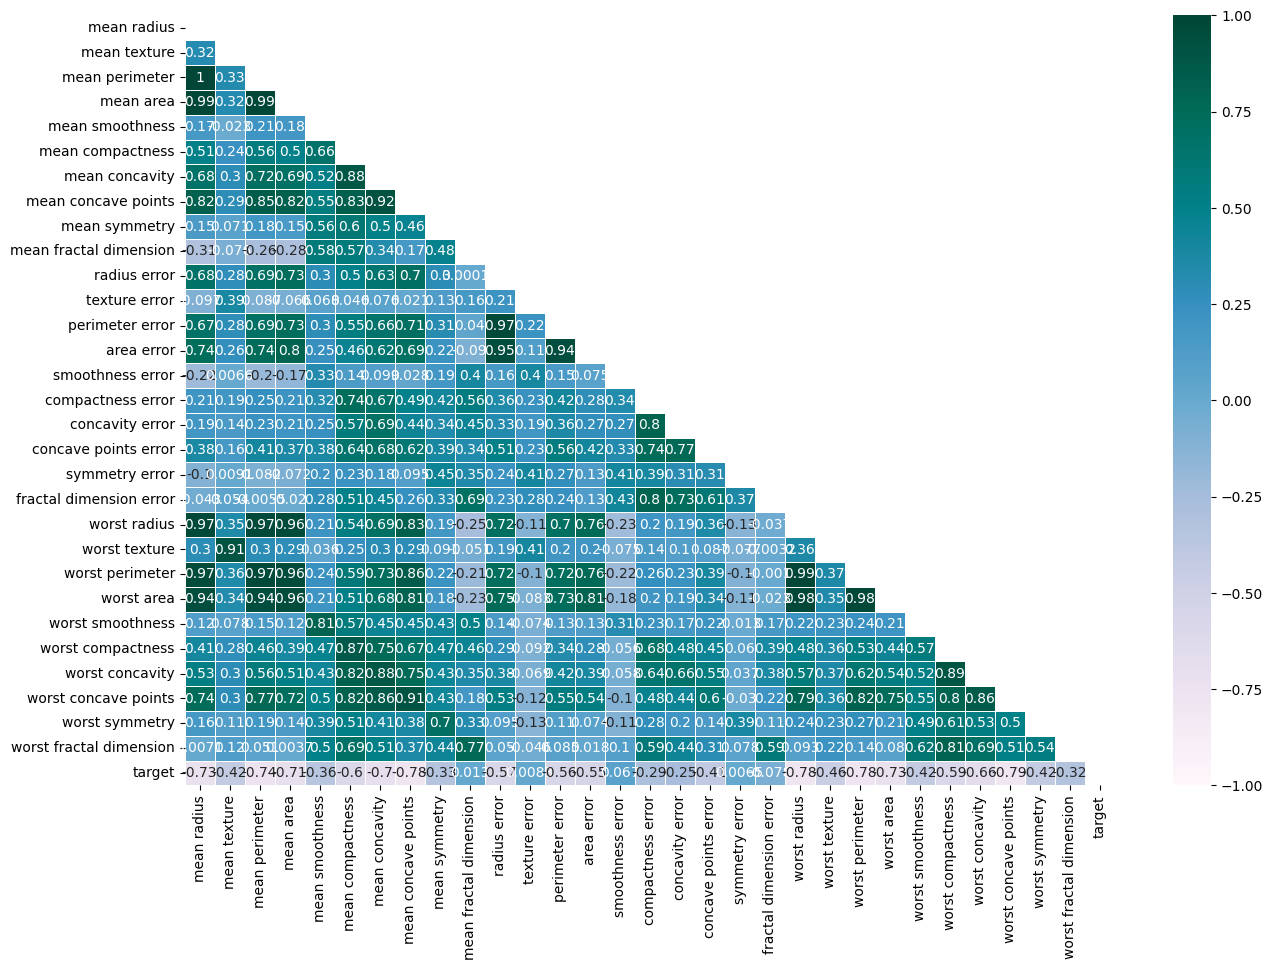

In [11]:
corr = data.corr()
matrix = np.triu(corr)
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask = matrix,
            annot=True,
            cmap = 'PuBuGn',
            linewidths = 0.5,
            vmin = -1, vmax = 1,)

plt.show()

In [25]:
# Seperate the features with close relationship to the target
target = corr.iloc[0:-1, -1]
filter = target[(target> .59) | (target <-.59)]
filtered_columns = filter.index.tolist()

In [26]:
# To have a data frame with specific colomns

df = data.loc[:, filtered_columns]
df.shape

(569, 12)

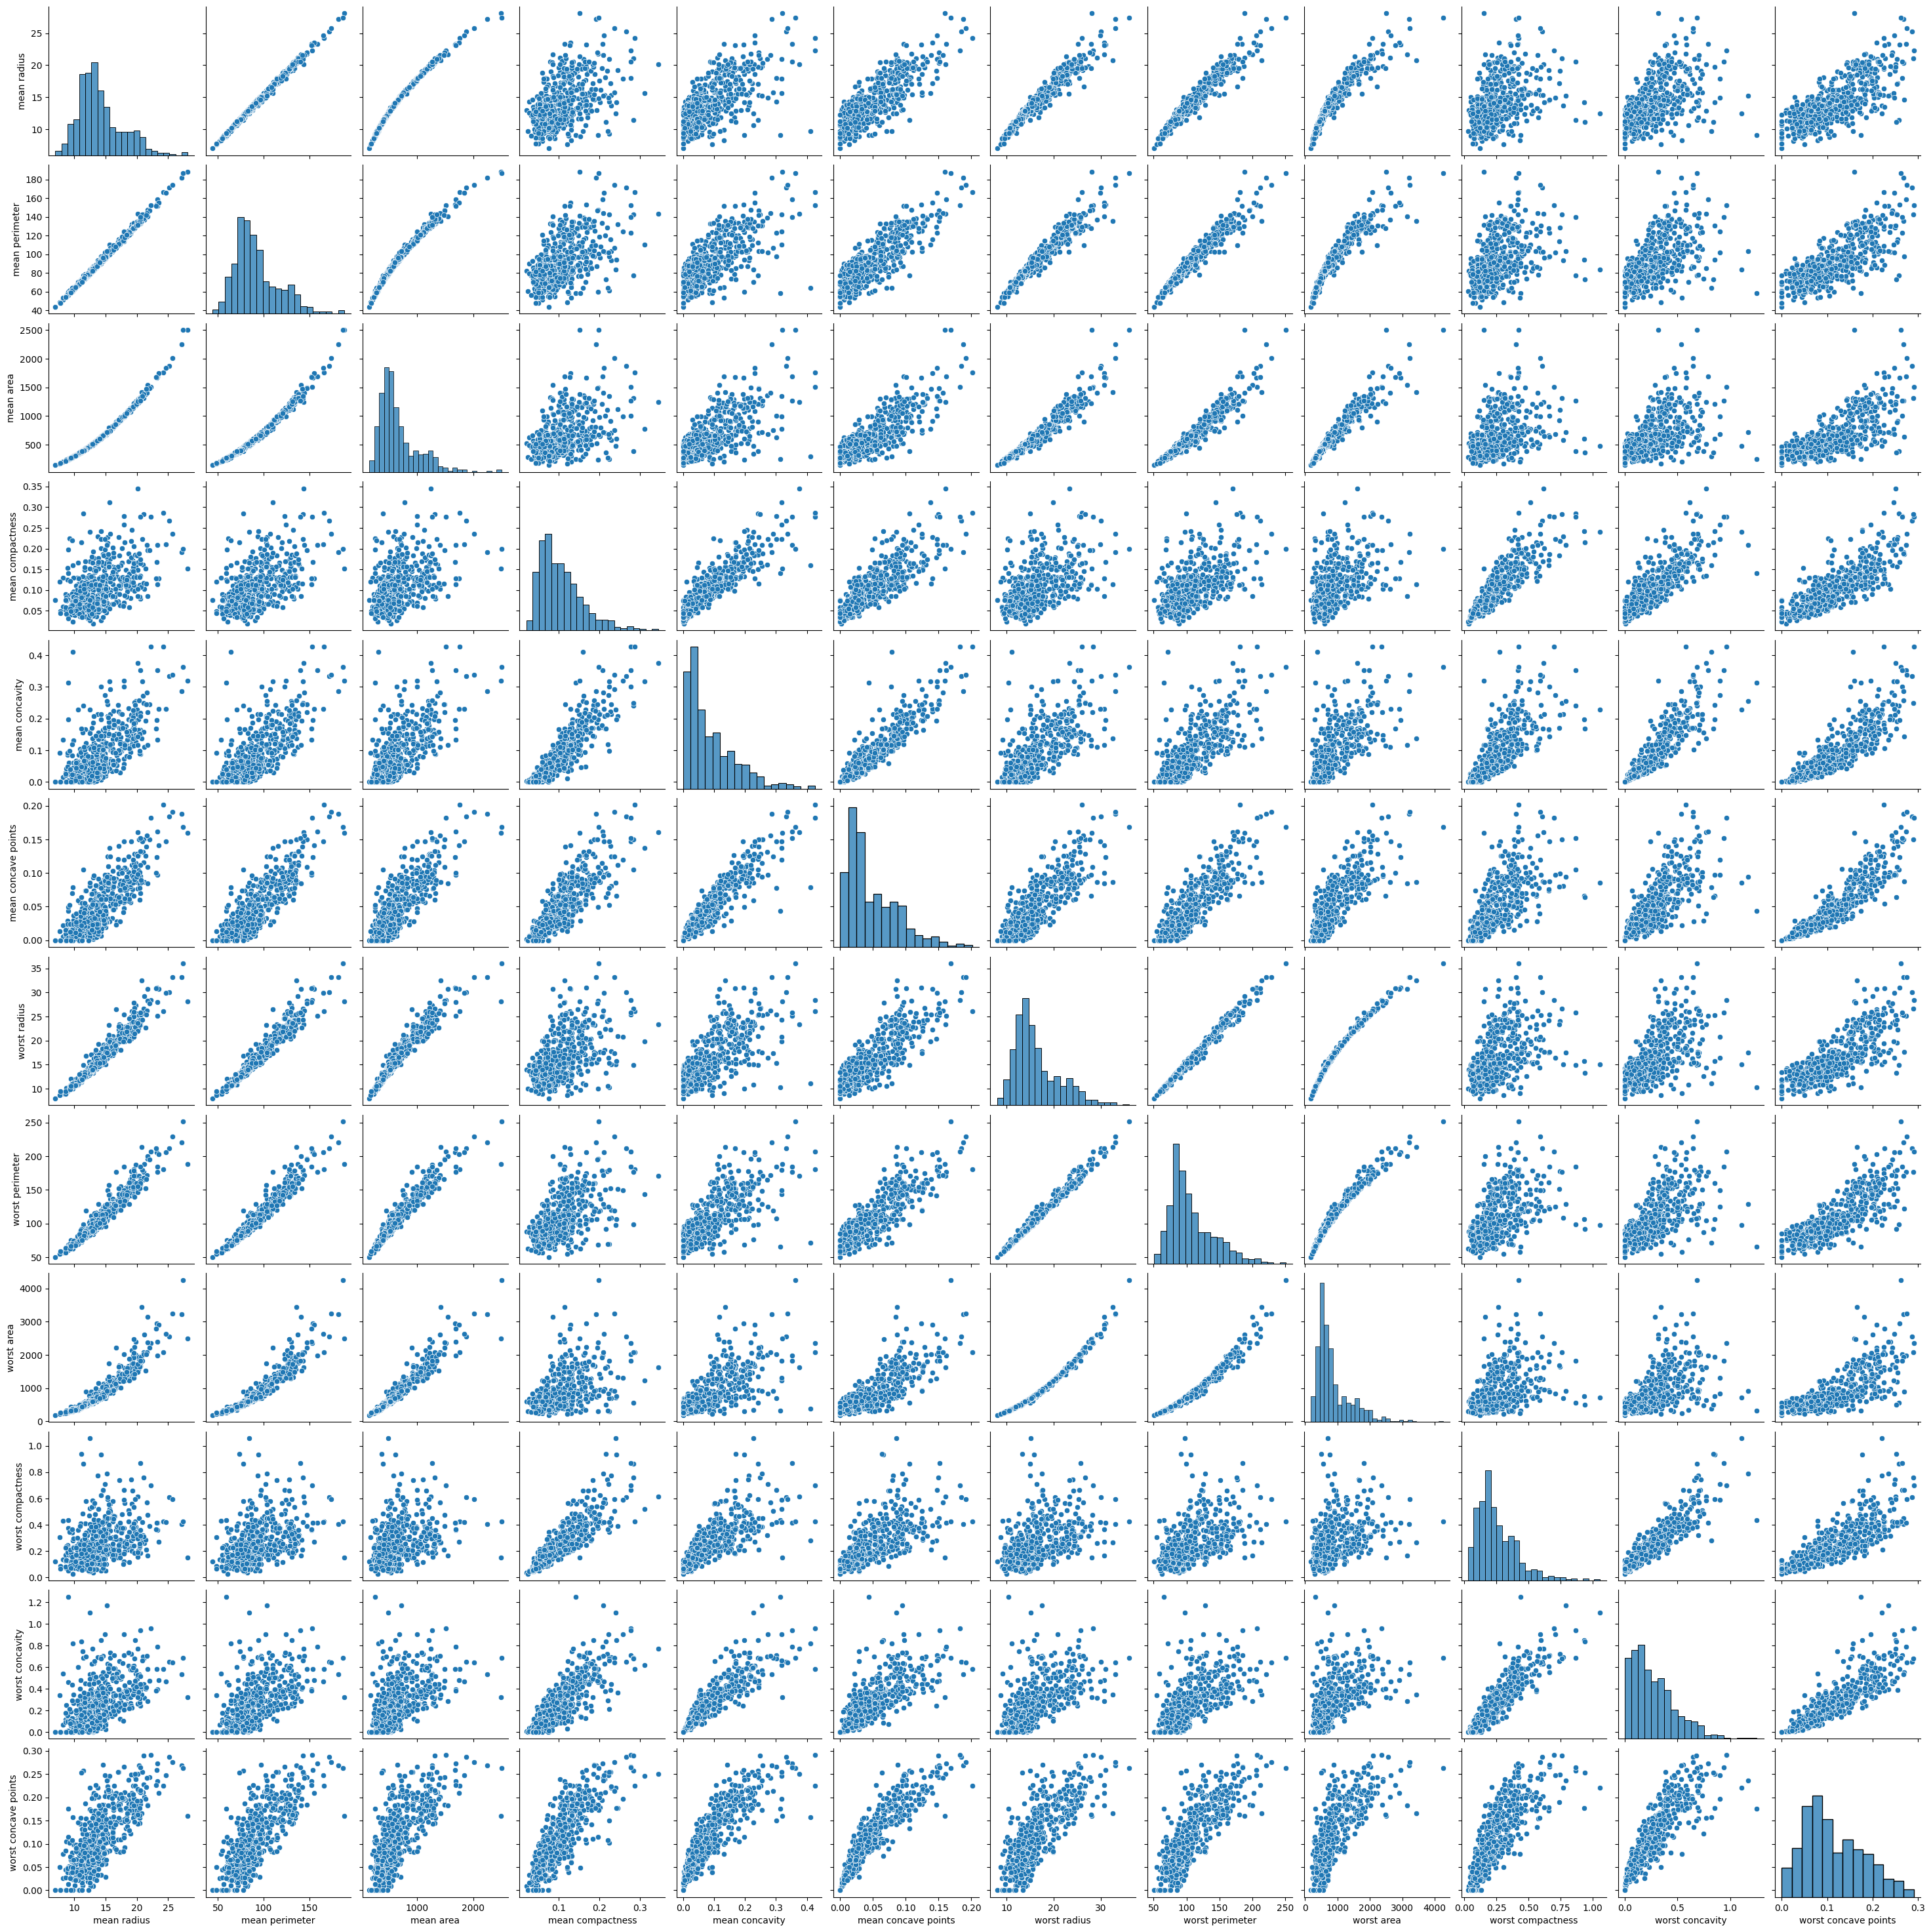

In [27]:
sns.pairplot(df)

In [34]:
dependent = data['target']
Independent = df
print(f'Independent shape is: {Independent.shape}')
print(28* '--')
print(f'Target value counts: {dependent.value_counts()}')

Independent shape is: (569, 12)
--------------------------------------------------------
Target value counts: target
1    357
0    212
Name: count, dtype: int64


Use filtered data

In [47]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Independent,
                                                    dependent,
                                                    test_size=0.2,
                                                    random_state=42)

print(f'#Train records: {X_train.shape[0]}')
print(f'#Test records: {y_test.shape[0]}')

#Train records: 455
#Test records: 114


In [48]:
# Scale data

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [49]:
# Finding best params with optuna for xgboost

def objective(trial):
    param = {
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_sc, y_train)
    preds = model.predict(X_test_sc)

    f1 = f1_score(y_test, preds)
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-09-16 11:50:11,809] A new study created in memory with name: no-name-eeb95950-1e99-4b21-873f-57794bfd06b1
[I 2024-09-16 11:50:11,873] Trial 0 finished with value: 0.965034965034965 and parameters: {'max_depth': 8, 'learning_rate': 0.07750563940157322, 'n_estimators': 79, 'subsample': 0.5357292164696534, 'colsample_bytree': 0.5624397479095362}. Best is trial 0 with value: 0.965034965034965.
[I 2024-09-16 11:50:11,943] Trial 1 finished with value: 0.9583333333333334 and parameters: {'max_depth': 10, 'learning_rate': 0.29284588996357847, 'n_estimators': 126, 'subsample': 0.8660741556407794, 'colsample_bytree': 0.9663554525381958}. Best is trial 0 with value: 0.965034965034965.
[I 2024-09-16 11:50:12,035] Trial 2 finished with value: 0.9583333333333334 and parameters: {'max_depth': 10, 'learning_rate': 0.09766092104468709, 'n_estimators': 71, 'subsample': 0.9506632335019537, 'colsample_bytree': 0.5214930083841576}. Best is trial 0 with value: 0.965034965034965.
[I 2024-09-16 11:50:

Best trial: 0.971830985915493
Best parameters: {'max_depth': 7, 'learning_rate': 0.21233452678124448, 'n_estimators': 92, 'subsample': 0.764869453775736, 'colsample_bytree': 0.6921336821696802}


In [56]:
xg_history = optuna.visualization.plot_optimization_history(study)
print('xg f1 Diagram\n')
xg_history

xg f1 Diagram



In [51]:
xg_params = optuna.visualization.plot_param_importances(study)
print('xg Hyperarameters Importance\n')
xg_params

Hyperarameters Importance



In [52]:
# Finding best params with optuna for SVM
svc = SVC
def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.1, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.1, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = svc(**param, random_state = 42)
    model.fit(X_train_sc, y_train)
    preds = model.predict(X_test_sc)

    f1 = f1_score(y_test, preds)

    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-09-16 11:51:01,588] A new study created in memory with name: no-name-3066b366-1b55-4e43-82f8-794e2b841d91
[I 2024-09-16 11:51:01,608] Trial 0 finished with value: 0.8554216867469879 and parameters: {'C': 0.4926230967875409, 'gamma': 0.020591011099107995, 'kernel': 'poly'}. Best is trial 0 with value: 0.8554216867469879.
[I 2024-09-16 11:51:01,623] Trial 1 finished with value: 0.8658536585365854 and parameters: {'C': 7.446769026395023, 'gamma': 0.011776172478366728, 'kernel': 'poly'}. Best is trial 1 with value: 0.8658536585365854.
[I 2024-09-16 11:51:01,644] Trial 2 finished with value: 0.8930817610062893 and parameters: {'C': 0.37854947075738404, 'gamma': 0.0004956934316609485, 'kernel': 'rbf'}. Best is trial 2 with value: 0.8930817610062893.
[I 2024-09-16 11:51:01,659] Trial 3 finished with value: 0.9655172413793103 and parameters: {'C': 3.1145795823986653, 'gamma': 0.001061323034000835, 'kernel': 'rbf'}. Best is trial 3 with value: 0.9655172413793103.
[I 2024-09-16 11:51:01,

Best trial: 0.993006993006993
Best parameters: {'C': 9.745639449646212, 'gamma': 0.08915514841279572, 'kernel': 'linear'}


In [53]:
svc_history = optuna.visualization.plot_optimization_history(study)
print('SVC f1 Diagram\n')
svc_history

SVC f1 Diagram



In [59]:
# Finding best params with optuna for GaussianNB
gb = GaussianNB
def objective(trial):
  param = {
      'priors': trial.suggest_categorical('priors', [None]),
      'var_smoothing': trial.suggest_float('var_smoothing', 1e-11, 1e-6, log = True)

  }
  model = gb(**param)
  model.fit(X_train_sc, y_train)
  preds = model.predict(X_test_sc)

  f1 = f1_score(y_test, preds)
  return f1

study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials = 50)

print(f'Best trial: {study.best_trial.value}')
print(f'Best parameters: {study.best_trial.params}')

[I 2024-09-16 11:56:25,859] A new study created in memory with name: no-name-a35b0afd-ba05-4212-893f-34a867b501fb
[I 2024-09-16 11:56:25,874] Trial 0 finished with value: 0.9722222222222222 and parameters: {'priors': None, 'var_smoothing': 5.788938312844026e-11}. Best is trial 0 with value: 0.9722222222222222.
[I 2024-09-16 11:56:25,884] Trial 1 finished with value: 0.9722222222222222 and parameters: {'priors': None, 'var_smoothing': 8.047946295346637e-09}. Best is trial 0 with value: 0.9722222222222222.
[I 2024-09-16 11:56:25,894] Trial 2 finished with value: 0.9722222222222222 and parameters: {'priors': None, 'var_smoothing': 4.960290449412853e-07}. Best is trial 0 with value: 0.9722222222222222.
[I 2024-09-16 11:56:25,904] Trial 3 finished with value: 0.9722222222222222 and parameters: {'priors': None, 'var_smoothing': 1.3890049375032577e-08}. Best is trial 0 with value: 0.9722222222222222.
[I 2024-09-16 11:56:25,914] Trial 4 finished with value: 0.9722222222222222 and parameters: {

Best trial: 0.9722222222222222
Best parameters: {'priors': None, 'var_smoothing': 5.788938312844026e-11}


In [60]:
# Finding best params with optuna for Random Forrest
rf = RandomForestClassifier
def objective (trial):
  param = {'n_estimators': trial.suggest_int('n_estimators', 5, 100),
           'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
           'max_depth': trial.suggest_int('max_depth', 2, 10),
           'min_samples_split':trial.suggest_int('min_samples_split', 2, 5),
           'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
           'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.01, 0.1)


  }
  model = rf(**param, random_state = 20)
  model.fit(X_train_sc, y_train)
  preds = model.predict(X_test_sc)

  f1 = f1_score(y_test, preds)
  return f1


study = optuna.create_study(direction= 'maximize')
study.optimize(objective, n_trials = 50)
print(f'Best trial: {study.best_trial.value}')
print(f'Best parameters: {study.best_trial.params}')

[I 2024-09-16 11:56:37,074] A new study created in memory with name: no-name-8d586a74-0e28-4909-85b0-c5334f91f78a
[I 2024-09-16 11:56:37,188] Trial 0 finished with value: 0.9655172413793103 and parameters: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.07749440027411396}. Best is trial 0 with value: 0.9655172413793103.
[I 2024-09-16 11:56:37,230] Trial 1 finished with value: 0.9583333333333334 and parameters: {'n_estimators': 9, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.046553735155869524}. Best is trial 0 with value: 0.9655172413793103.
[I 2024-09-16 11:56:37,311] Trial 2 finished with value: 0.9655172413793103 and parameters: {'n_estimators': 39, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.08096582941779719}. Best is trial 0 with value: 0.965517241379

Best trial: 0.9793103448275862
Best parameters: {'n_estimators': 33, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.06491280410674677}


SVM F1-score: 0.9930
--------------------------------------------------------


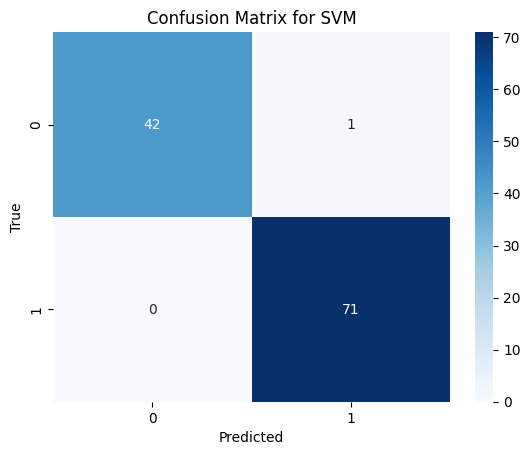

--------------------------------------------------------
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [72]:
# SVM

svm = SVC(C = 9.745,
          gamma = .089,
          kernel = 'linear',
          random_state = 42)
svm.fit(X_train_sc, y_train)
svm_pred = svm.predict(X_test_sc)

# Calculate F1-score
f1_svm = f1_score(y_test, svm_pred)
print(f"SVM F1-score: {f1_svm:.4f}")
print(28*'--')
# Confusion matrix
cm_svm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(28*'--')
# Classification report
print(f"SVM Classification Report:\n", classification_report(y_test, svm_pred))
